Simulasi Gantry Motor ICCAS
Oleh: Cristian MP Napitupulu

"Simulasi" pada file ini merujuk pada while-loop di bawah.
Pada proses simulasi x dan l memiliki satuan meter.
Pada proses simulasi theta memiliki satuan radian.
Namun, theta pada proses analisis respon (rise time, settling time, dll) theta memiliki satuan derajat

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def moving_average_cumsum(data, window_size):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

class state:
    def __init__(self, dt_, duration_, x0=0.0, x_dot0=0.0):
        self.dt = dt_
        self.duration = duration_
        self._x = np.zeros(int(self.duration / self.dt))
        self._x_dot = np.zeros(int(self.duration / self.dt))
        self._x[0] = x0
        self._x_dot[0] = x_dot0


def sign_matrix(X):
    Y = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i, j] > 0:
                Y[i, j] = 1
            elif X[i, j] < 0:
                Y[i, j] = -1
            else:
                Y[i, j] = 0
    return Y

matrix_A = np.matrix(
    [
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]
)

matrix_B = np.matrix(
    [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
)

matrix_G = np.matrix([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])

def update_Matrix_A(mc, mt, bt, br, l, l_dot, theta, theta_dot, matrix_A):
    matrix_A[1, 1] = -bt / mt
    matrix_A[1, 3] = -br * np.sin(theta) / mt
    matrix_A[3, 1] = -bt * np.sin(theta) / mt
    matrix_A[3, 3] = -(mc * (np.sin(theta)) ** 2 / mt + 1) * (br / mt)
    matrix_A[3, 5] = l * theta_dot
    matrix_A[5, 1] = -bt * np.cos(theta) / (mt * l)
    matrix_A[5, 3] = -br * np.sin(theta) * np.cos(theta) / (mt * l)
    matrix_A[5, 5] = -2 * l_dot / l

def update_Matrix_B(mc, mt, l, theta, matrix_B):
    matrix_B[1, 0] = 1 / mt
    matrix_B[1, 1] = np.sin(theta) / mt
    matrix_B[3, 0] = np.sin(theta) / mt
    matrix_B[3, 1] = (mc * (np.sin(theta)) ** 2 / mt + 1) / mc
    matrix_B[5, 0] = np.cos(theta) / (mt * l)
    matrix_B[5, 1] = np.sin(theta) * np.cos(theta) / (mt * l)

def update_Matrix_G(g, l, theta, matrix_G):
    matrix_G[1, 0] = 0.0
    matrix_G[3, 0] = g * np.cos(theta)
    matrix_G[5, 0] = -g * np.sin(theta) / l

def matrix_Lambda(lambda1, lambda2):
    matrix_Lambda = np.matrix([[lambda1, 0.0, 0.0], [0.0, lambda2, 0.0]])
    return matrix_Lambda

def matrix_Alpha(alpha1, alpha2):
    matrix_alpha = np.matrix([[alpha1], [alpha2]])
    return matrix_alpha

In [50]:
# Hasilkan nilai variasi random untuk x, l, theta, dan mc

generate_variation = []
variation_number = 5

# Baris ini digunakan untuk menghasilkan nilai variasi random
x_range = [0.0, 2.0]
l_range = [0.2, 1.8]
theta_range = [-45.0, 45.0]
mc_range = [0.4, 1.6]

for i in range (variation_number):
    temp_ = [0.0, 0.0, 0.0, 0.0]
    temp_[0] = round(np.random.uniform(x_range[0], x_range[1]), 2)
    temp_[1] = round(np.random.uniform(l_range[0], l_range[1]), 2)
    temp_[2] = round(np.random.uniform(theta_range[0], theta_range[1]), 2)
    temp_[3] = round(np.random.uniform(mc_range[0], mc_range[1]), 2)
    generate_variation.append(temp_)

# Nilai variasi yang sudah dihasilkan kemudian di-print
print(generate_variation)

# Nilai variasi yang sudah diprint kemudian di-copy ke sini
# Jika bagian ini dihapus (di-comment),...
# ...maka akan dihasilkan variasi yang berbeda setiap kali program dijalankan
# Jadi, gunakan sesuai kebutuhan
generate_variation = [[1.25, 1.17, -39.95, 0.99], [0.02, 1.51, -3.64, 0.43], [1.88, 0.68, 18.23, 0.75], [1.16, 0.3, -16.24, 1.28], [1.41, 1.2, -7.55, 1.3]]

[[1.54, 0.33, -30.76, 1.52], [1.27, 0.77, 5.23, 1.04], [1.89, 1.06, 3.85, 0.63], [1.95, 0.92, 17.54, 0.8], [1.11, 1.45, 12.66, 0.62]]


In [51]:
# Deklarasi variabel yang akan digunakan
# Physical Parameter
mt = 1.0
bt = 5.0
br = 5.0
g = 9.81

x_max_error = 0.01
x_dot_max_steady_state = 0.01

l_max_error = 0.01
l_dot_max_steady_state = 0.01

theta_max_error = 0.01 * 180 / np.pi # degree
theta_dot_max_steady_state = 0.0001 * 180 / np.pi # degree

# Simulation Parameter
dt = 0.005
timeout_duration = 20.0
steady_state_checking_duration_window = 1.0

k = 1.0
lambda1 = 0.75
lambda2 = 0.7
alpha1 = 1.5
alpha2 = 0.0

matrix_lambda = np.matrix([[lambda1, 0.0, 0.0], [0.0, lambda2, 0.0]])
matrix_alpha = np.matrix([[alpha1], [alpha2]])
matrix_I = np.matrix([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

In [52]:
# Buat variabel untuk menyimpan hasil simulasi secara global...
# ...untuk keperluan plotting di akhir
x = []
l = []
theta = []
x_dot = []
l_dot = []
theta_dot = []
Sx = []
Sl = []
Fx = []
Fl = []

for i in range (variation_number):
    x_initial = generate_variation[i][0]
    l_initial = generate_variation[i][1]
    theta_initial = generate_variation[i][2] * np.pi / 180
    mc_ = generate_variation[i][3]

    control_limit = 2 * mc_ * g

    y_initial = np.matrix([[x_initial], [l_initial], [theta_initial]])
    y_desired = np.matrix([[1.0], [1.0], [0.0]])

    # Buat variabel untuk menyimpan hasil simulasi secara lokal untuk setiap variasi
    x_ = [x_initial]
    l_ = [l_initial]
    theta_ = [theta_initial]
    x_dot_ = [0.0]
    l_dot_ = [0.0]
    theta_dot_ = [0.0]
    Sx_ = [0.0]
    Sl_ = [0.0]
    Fx_ = [0.0]
    Fl_ = [0.0]

    j = 0
    while j < int(timeout_duration/dt):
        # Update matrix A, B, dan G
        update_Matrix_A(
            mc_, mt, bt, br, l_[j], l_dot_[j], theta_[j], theta_dot_[j], matrix_A
        )
        update_Matrix_B(mc_, mt, l_[j], theta_[j], matrix_B)
        update_Matrix_G(g, l_[j], theta_[j], matrix_G)

        # Update matrix A_cap, B_cap, dan G_cap
        matrix_A_cap = np.matrix(
            [
                [matrix_A[1, 1], matrix_A[1, 3], matrix_A[1, 5]],
                [matrix_A[3, 1], matrix_A[3, 3], matrix_A[3, 5]],
            ]
        )
        matrix_B_cap = np.matrix(
            [
                [matrix_B[1, 0], matrix_B[1, 1]],
                [matrix_B[3, 0], matrix_B[3, 1]],
            ]
        )
        matrix_G_cap = np.matrix([[matrix_G[1, 0]], [matrix_G[3, 0]]])

        # Update y dan y_dot yang berisi x, l, theta, x_dot, l_dot, dan theta_dot
        y = np.matrix([[x_[j]], [l_[j]], [theta_[j]]])
        y_dot = np.matrix([[x_dot_[j]], [l_dot_[j]], [theta_dot_[j]]])

        # Update sliding surface dan control
        sliding_surface_now = np.matrix([[Sx_[j]], [Sl_[j]]])
        sliding_surface_now = (
            matrix_lambda * (y_desired - y) # type: ignore
            - matrix_I * y_dot
            - matrix_alpha * theta_[j]
        )
        control_now = np.matrix([[Fx_[j]], [Fl_[j]]])
        control_now = np.linalg.inv(matrix_B_cap) * (
            -np.matmul((matrix_A_cap + matrix_lambda), y_dot)
            - matrix_G_cap
            - matrix_alpha * theta_dot_[j] + k * sign_matrix(sliding_surface_now)
        )

        # Control akan dibatasi agar tidak melebihi batas yang ditentukan
        # Tetapi nilai control_limit ini tidak akan pernah tercapai
        # Atur control_limit sesuai kebutuhan
        # control_now = np.clip(control_now, -control_limit, control_limit)

        # Buat array untuk persamaan state-space
        state_now = np.matrix(
            [
                [x_[j]],
                [x_dot_[j]],
                [l_[j]],
                [l_dot_[j]],
                [theta_[j]],
                [theta_dot_[j]],
            ]
        )

        # Lakukan integrasi numerik untuk mendapatkan state selanjutnya
        # state_next = state_now + state_now_dot * dt
        state_now = state_now + dt * (
            matrix_A * state_now + matrix_B * control_now + matrix_G
        )

        # Update nilai x, l, theta, x_dot, l_dot, dan theta_dot
        x_.append(state_now[0, 0])
        x_dot_.append(state_now[1, 0])
        l_.append(state_now[2, 0])
        l_dot_.append(state_now[3, 0])
        theta_.append(state_now[4, 0])
        theta_dot_.append(state_now[5, 0])

        # Update nilai sliding surface dan control
        Fx_.append(control_now[0, 0])
        Fl_.append(control_now[1, 0])

        Sx_.append(sliding_surface_now[0, 0])
        Sl_.append(sliding_surface_now[1, 0])

        # Print progress
        if (j % 100):
            print("Variation ", i + 1, ": Progress: ", round(j*dt / timeout_duration * 100, 1), "%", end="\r")

        j += 1
    
    print ("Variation ", i + 1, ": Simulation complete.")

    theta_ = [i * 180 / np.pi for i in theta_]
    theta_dot_ = [i * 180 / np.pi for i in theta_dot_]
    
    # Simpan hasil simulasi setiap variasi ke dalam variabel global
    x.append(x_)
    l.append(l_)
    theta.append(theta_)
    x_dot.append(x_dot_)
    l_dot.append(l_dot_)
    theta_dot.append(theta_dot_)
    Sx.append(Sx_)
    Sl.append(Sl_)
    Fx.append(Fx_)
    Fl.append(Fl_)


Variation  1 : Simulation complete.
Variation  2 : Simulation complete.
Variation  3 : Simulation complete.
Variation  4 : Simulation complete.
Variation  5 : Simulation complete.


In [53]:
# Bagian ini berisi fungsi untuk analisis respon sistem

settle_percentage = 0.02 # 2%
begin_rise_percentage = 0.00 # 0%
end_rise_percentage = 0.95 # 95%

# Fungsi untuk mencari nilai rise time
def rise_time(data, setpoint):
    begin_rise_time_percentage = begin_rise_percentage
    end_rise_time_percentage = end_rise_percentage
    begin_rise_time = 0.0
    end_rise_time = 0.0
    amplitude = abs(data[0] - setpoint)
    for i in range(len(data)):
        if abs(data[i] - setpoint) <= (1 - begin_rise_time_percentage) * amplitude:
            begin_rise_time = i * dt
            break
    for i in range(len(data)):
        if abs(data[i] - setpoint) <= (1 - end_rise_time_percentage) * amplitude:
            end_rise_time = i * dt
            break
    return round(end_rise_time - begin_rise_time, 3)

# Fungsi untuk mencari nilai settling time
def settling_time(data, setpoint, error_max=0.0):
    settling_time_percentage = settle_percentage
    amplitude = abs(data[0] - setpoint) * settling_time_percentage
    if error_max != 0.0:
        amplitude = error_max
        
    settling_time = 0.0
    for i in range(len(data) - 1, 0, -1):
        if abs(data[i] - setpoint) >= amplitude:
            settling_time = i * dt
            break
    return round(settling_time, 3)

# Fungsi untuk mencari nilai RMSE steady state
def rmse_steady_state(data, setpoint, error_max=0.0):
    settling_time_percentage = settle_percentage
    amplitude = abs(data[0] - setpoint) * settling_time_percentage
    if error_max != 0.0:
        amplitude = error_max
        
    settling_index = 0
    for i in range(len(data) - 1, 0, -1):
        if abs(data[i] - setpoint) >= amplitude:
            settling_index = i
            break
    
    sum_squared_error = 0.0
    for i in range (len(data)-1, settling_index, -1):
        sum_squared_error += (data[i] - setpoint) ** 2
    return round(np.sqrt(sum_squared_error / (len(data) - settling_index)), 3)

# print("Rise Time: ", rise_time(x[0], y_desired[0, 0]))
# print("Settling Time: ", settling_time(x[0], y_desired[0, 0]))
# print("RMSE: ", rmse_steady_state(x[0], y_desired[0, 0]))

In [54]:
# Buat array untuk menyimpan hasil analisis respon sistem
result = []

for i in range(variation_number):
    result.append(
        {
            "Variation": i + 1,
            "Rise time x (s)": rise_time(x[i], y_desired[0, 0]),
            "Settling time x (s)": settling_time(x[i], y_desired[0, 0]),
            "RMSE x (m)": rmse_steady_state(x[i], y_desired[0, 0]),
            "Rise time l (s)": rise_time(l[i], y_desired[1, 0]),
            "Settling time l (s)": settling_time(l[i], y_desired[1, 0]),
            "RMSE l (m)": rmse_steady_state(l[i], y_desired[1, 0]),
            "Rise time theta (s)": rise_time(theta[i], y_desired[2, 0]),
            "Settling time theta (s)": settling_time(theta[i], y_desired[2, 0], error_max= theta_max_error),
            "RMSE theta (degree)": rmse_steady_state(theta[i], y_desired[2, 0], error_max= theta_max_error),
        }
    )

# Simpan hasil analisis respon sistem ke dalam file excel
# print(result)
df = pd.DataFrame(result)
df.to_excel("result.xlsx", index=False)


Saved as  x vs time.svg
Saved as  l vs time.svg
Saved as  theta vs time.svg
Saved as  x_dot vs time.svg
Saved as  l_dot vs time.svg
Saved as  theta_dot vs time.svg
Saved as  Sx vs time.svg
Saved as  Sl vs time.svg
Saved as  Fx vs time.svg
Saved as  Fl vs time.svg


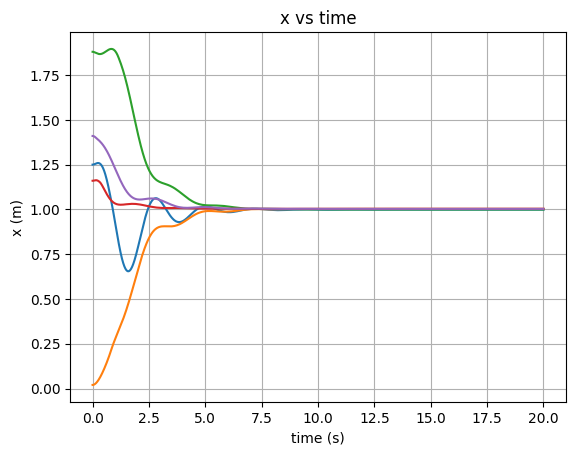

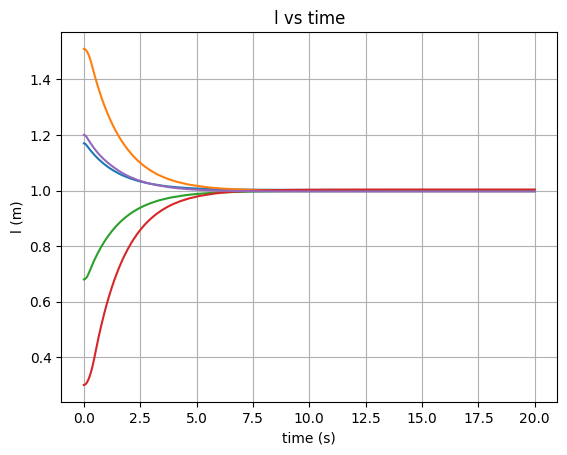

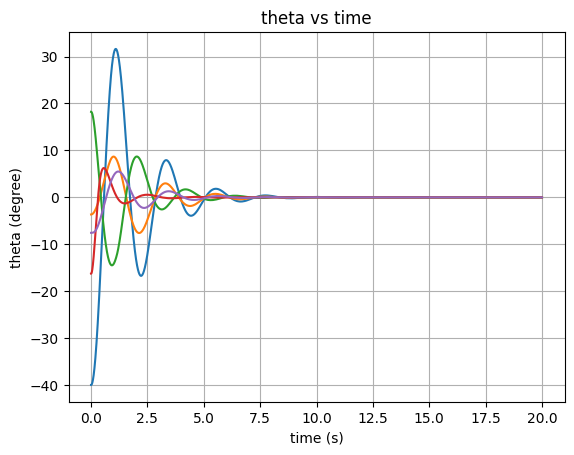

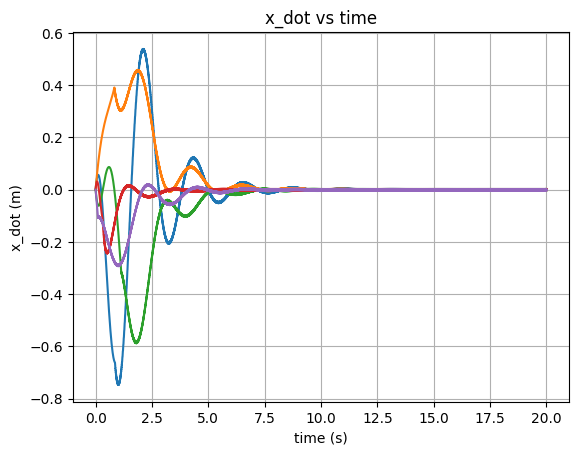

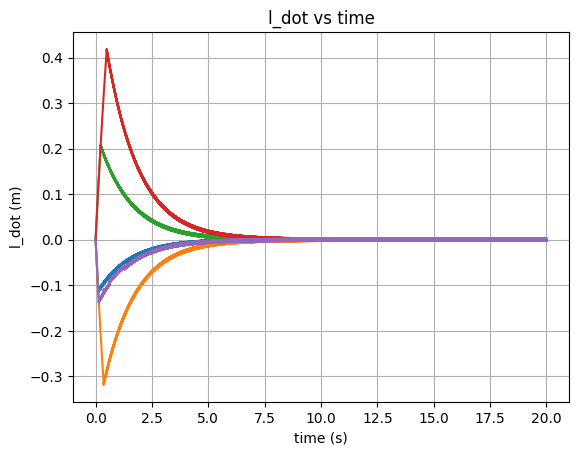

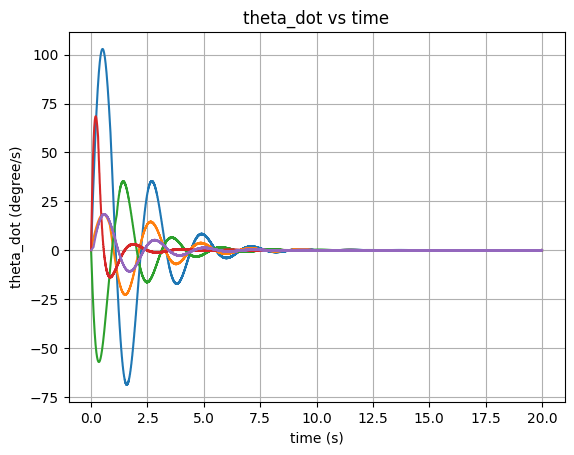

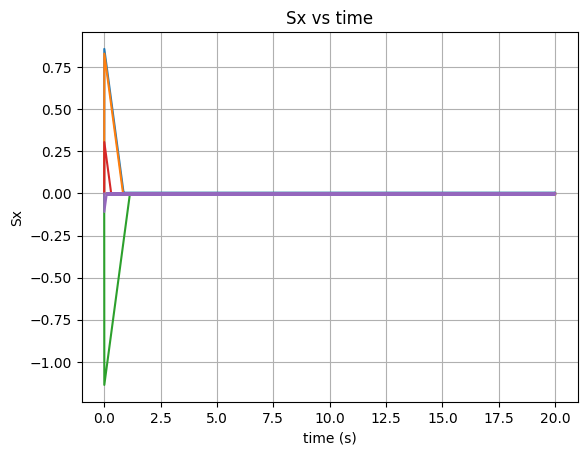

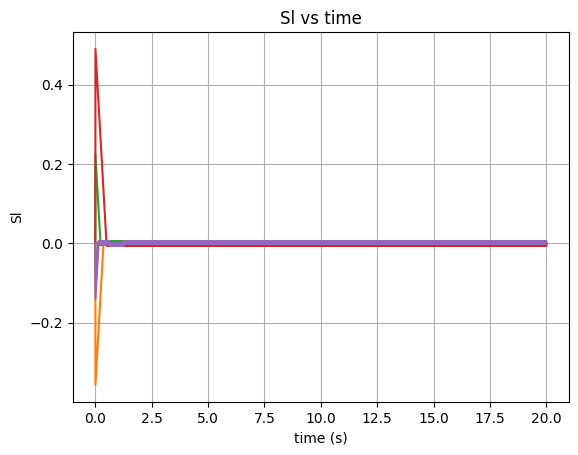

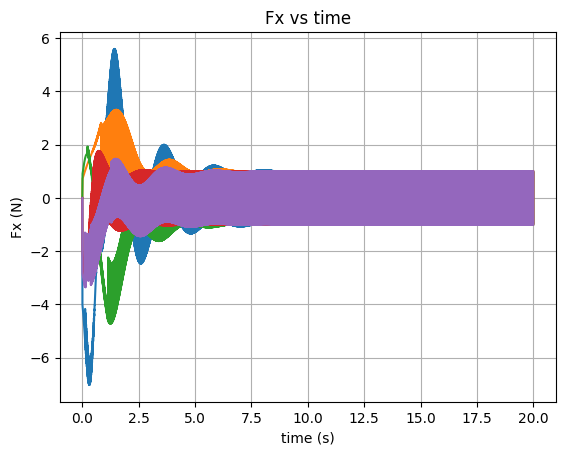

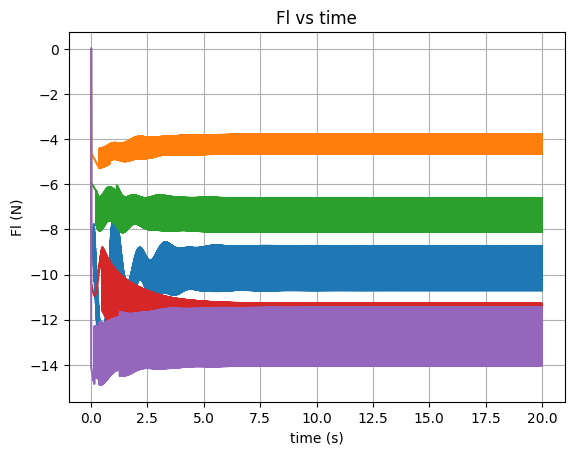

In [55]:
# Bagian ini berisi fungsi untuk plotting
# plotting dilakukan untuk setiap state pada variasi yang berbeda
def multi_plot(state_version, state_name = "state", unit = "m", variation_=[[]], save_path='Simulasi/Gambar/Variasi ICA/'):
    plt.figure(state_name)
    for i in range(len(state_version)):
        time = np.arange(0, len(state_version[i])*dt, dt)
        r = 255 * (i + 1) / len(state_version)
        g = 255 * (len(state_version) - i) / len(state_version)
        b = 255 * (i + 1) / len(state_version)
        rgb_color = (r / 255, g / 255, b / 255)

        variation_label = (
            "Var"
            + str(i + 1)
            + ": x_init"
            + " = "
            + str(variation_[i][0])
            + ", l_init"
            + " = "
            + str(variation_[i][1])
            + ", theta_init"
            + " = "
            + str(variation_[i][2])
            + ", mc"
            + " = "
            + str(variation_[i][3])
        )

        plt.plot(time, state_version[i], label = variation_label)
    
    # plt.legend(loc="best", bbox_to_anchor=(0.98, -0.125))
    plt.xlabel("time (s)")
    y_label = state_name + " (" + unit + ")"
    if (unit == ""):
        y_label = state_name
    plt.ylabel(y_label)
    plt.title(state_name + " vs time")
    plt.grid(True)
    save_as = state_name+" vs time.svg"
    plt.savefig(save_as, format='svg', transparent=True, bbox_inches='tight')
    print("Saved as ", save_as)

    # plt.show()


multi_plot(x, state_name="x", unit="m", variation_= generate_variation)
multi_plot(l, state_name="l", unit="m", variation_= generate_variation)
multi_plot(theta, state_name="theta", unit="degree", variation_= generate_variation)
multi_plot(x_dot, state_name="x_dot", unit="m", variation_= generate_variation)
multi_plot(l_dot, state_name="l_dot", unit="m", variation_= generate_variation)
multi_plot(theta_dot, state_name="theta_dot", unit="degree/s", variation_= generate_variation)
multi_plot(Sx, state_name="Sx", unit="", variation_= generate_variation)
multi_plot(Sl, state_name="Sl", unit="", variation_= generate_variation)
multi_plot(Fx, state_name="Fx", unit="N", variation_= generate_variation)
multi_plot(Fl, state_name="Fl", unit="N", variation_= generate_variation)


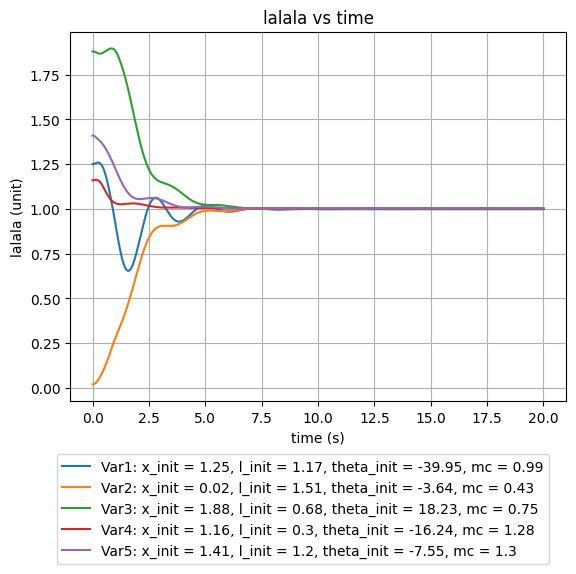

In [56]:
plt.figure("lalala")
for i in range(len(x)):
    time = np.arange(0, len(x[i]) * dt, dt)

    r = 255 * (i + 1) / len(x)
    g = 255 * (len(x) - i) / len(x)
    b = 255 * (i) / len(x)
    rgb_color = (r / 255, g / 255, b / 255)

    variation_label = (
        "Var"
        + str(i + 1)
        + ": x_init"
        + " = "
        + str(generate_variation[i][0])
        + ", l_init"
        + " = "
        + str(generate_variation[i][1])
        + ", theta_init"
        + " = "
        + str(generate_variation[i][2])
        + ", mc"
        + " = "
        + str(generate_variation[i][3])
    )

    plt.plot(time, x[i], label=variation_label)

plt.legend(loc="best", bbox_to_anchor=(0.98, -0.125))
plt.xlabel("time (s)")
y_label = "lalala" + " (" + "unit" + ")"
if "unit" == "":
    y_label = "lalala"
plt.ylabel(y_label)
plt.title("lalala" + " vs time")
plt.grid(True)
save_as = "lalala" + " vs time.png"
plt.savefig(save_as, transparent=True, bbox_inches="tight")